# Data Augmentation

## 학습 내용 

1. Augmentation 적용 (1) 데이터 불러오기
2. Augmentation 적용 (2) Augmentation 적용하기
3. Augmentation 적용 (3) 비교 실험하기
4. 심화 기법 (1) Cutmix Augmentation
5. 심화 기법 (2) Mixup Augmentation
6. 프로젝트: CutMix 또는 Mixup 비교 실험하기

## 데이터 불러오기

* 라이브러리 불러오기

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

* GPU 확인

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

* tfds에 있는 stanford_dogs를 사용합니다.
* 120개의 견종 이미지
* 총 20580장 이미지, 12000 학습, 8580 평가용 데이터 세트.

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

2022-10-05 12:51:34.361648: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-05 12:51:34.709245: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6668 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


* 데이터 확인

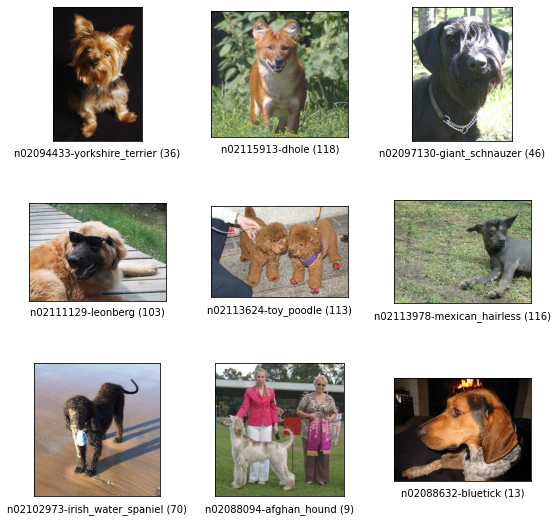

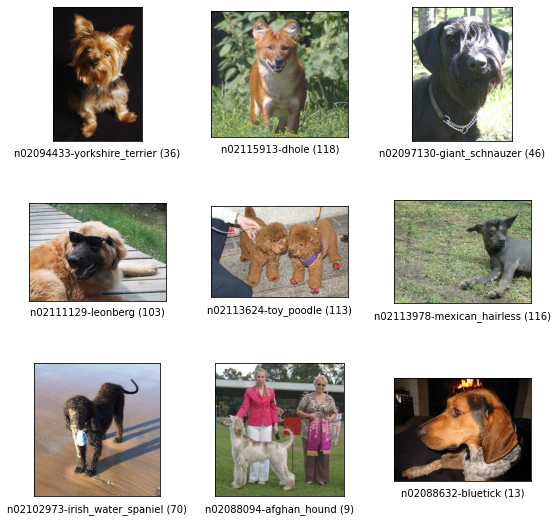

In [4]:
tfds.show_examples(ds_train, ds_info)

## Augmentation 적용하기 

* 기본적인 전처리 함수 만들기
* 이미지와 라벨을 입력받고
* 이미지의 크기를 (224,224)로 재조정합니다.
* 그리고 0~1의 float으로 normalize 합니다.
* tf.cast() : 텐서를 새로운 type으로 캐스팅한다.

In [5]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

* random_flip_left_right : 무작위 좌우 대칭
* random_brightness() : 무작위 밝기
* clip_by_value() : min 보다 작은 값은 min으로 max보다 큰 값은 max로 만든다.

In [6]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

* apply_normalize_on_dataset() : Augmentation을 통해 나온 다양한 형태의 가공한 형태의 새로운 데이터셋을 얻게 되는 모든 과정을 구현한 메인 함수
* 일반적인 전처리 과정들인 normalize, resize과 augmentation과 shuffle을 적용
* 단, test 데이터에는 shuffle 이나 augmentation 적용 안함.
* with_aug 매개변수를 통해 augmentation의 적용여부를 결정
* [tf.data.Datasets.map()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) : dataset의 모든 요소에 map 함수를 적용하여 변화된 요소들을 가지는 새로운 dataset을 반환합니다.
* [map 함수](https://jimmy-ai.tistory.com/50) :
  - 적용할 함수와 순회 가능한 객체를 파라미터로 넣습니다.
  - 순회 가능한 객체(list 등)의 각 원소에 지정한 함수를 각각 적용하여 결과를 반환하는 함수.
  - map 함수를 적용하면 결과값이 map 객체가 됩니다. 여기서는 index 접근이 안되기 때문에 주로 list나 다른 순회 가능 객체로 바꿔줍니다.
* [repeat 함수](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#repeat)
  - 이 데이터셋을 반복합니다.
  - [1,2,3]을 repeat(3) 하면 [1,2,3,1,2,3,1,2,3]
* [prefetch 함수](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch)
  - 연산에 필요한 데이터를 미리 가져오는 것
  - 현재 요소를 계산할 때 뒤의 요소를 미리 준비하는 것
  - latency(지연시간)과 throughput(스루풋)을 향상시킴 - prefetch한 요소들을 추가적인 메모리 사용을 통해서

In [7]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    # train set가 아니고 augmentation을 적용한다고 할 때
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        # ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

* Random Augmentation 직접 구현하기


In [8]:
def augment2(image,label):
    # RGB 변환
    image = tf.image.random_hue(image, 0.5)
    # 대비 변환
    image = tf.image.random_contrast(image, 0.3, 1)
    # 밝기 변환
    image = tf.image.random_brightness(image, max_delta=0.5)
    # 범위 안으로 클립
    image = tf.clip_by_value(image, 0, 1)
    return image, label

## 비교실험 하기

* Augmentation을 적용한 데이터를 학습시킨 모델과 적용하지 않은 데이터를 학습시킨 모델의 성능입니다.
* ResNet50과 ImagNet으로 훈련된 모델을 가져옴.
* include_top은 마지막 FCN 포함 여부
* inclue_top을 사용하는 이유는 ImageNet과 우리가 사용하는 데이터가 서로 다른 클래스를 가지기 때문에 마지막 FCN의 구조 또한 다르게 해주기 위해서

In [9]:
# 우리가 사용할 데이터셋의 class의 개수를 구합니다.
num_classes = ds_info.features["label"].num_classes
# 우리가 사용할 데이터에 맞춘 resnet을 만들어 봅시다. 
resnet50 = keras.models.Sequential([
    # resnet50을 불러옵니다.(ImageNet으로 훈련되있는)
    keras.applications.resnet.ResNet50(
        # class 개수가 다르기 때문에 마지막 FCN(softmax 포함되어있는)을 제외해줍니다. = (include_top = false)
        include_top=False,
        # ImageNet으로 훈련된 가중치들을 불러옵니다.
        weights='imagenet',
        # 우리가 사용할 데이터셋에 해당하는 입력 값의 크기 입니다.
        input_shape=(224,224,3),
        # pooling 방법을 avg_pooling을 사용합니다.
        pooling='avg',
    ),
    # 새로운 Data에 맞는 class 개수에 따라 FCN을 만듭니다.
    keras.layers.Dense(num_classes, activation='softmax')
])

* Augmentation을 적용한 데이터셋으로 학습할 ResNet을 하나 더 만들어줌

In [10]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

* augmentation에 따른 전처리 적용

In [11]:
(ds_train, ds_test), ds_info = tfds.load(
    # stanford_dogs dataset을 가져옵니다.
    'stanford_dogs',
    # train과 test로 나뉜다.
    split=['train', 'test'],
    # (input, label) 형태로 나옵니다.
    as_supervised=True,
    shuffle_files=True,
    # 추가로 info를 반환합니다.
    with_info=True,
)
# train, test와 aug 적용에 따라 맞춰서 전처리를 적용합니다.
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [12]:
EPOCH = 2

resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate = 0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/2


2022-10-05 12:51:44.242950: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


750/750 [==============================] - 116s 146ms/step - loss: 2.2366 - accuracy: 0.4297 - val_loss: 3.7764 - val_accuracy: 0.1484
Epoch 2/2
750/750 [==============================] - 110s 146ms/step - loss: 0.7471 - accuracy: 0.7919 - val_loss: 1.2387 - val_accuracy: 0.6414


In [13]:
aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate = 0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/2
750/750 [==============================] - 116s 147ms/step - loss: 2.3019 - accuracy: 0.4195 - val_loss: 3.1303 - val_accuracy: 0.2400
Epoch 2/2
750/750 [==============================] - 112s 146ms/step - loss: 0.9954 - accuracy: 0.7147 - val_loss: 1.4870 - val_accuracy: 0.5862


* 훈련과정 시각화

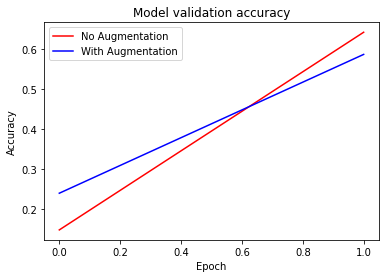

In [14]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

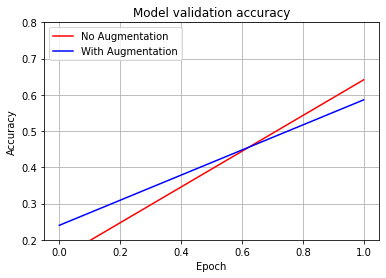

In [15]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
# plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
plt.ylim(0.2, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

## Cutmix Augmentation

* Cutmix : 이미지를 자른 뒤 섞는다.
* Mixup : 특정 비율로 픽셀 값을 섞는 법
* Cutout : 이미지를 잘라내는 방식

### 1. 이미지 섞기

* bounding box : 이미지에서 잘라서 섞어주는 영역
* [tf.dataset.take()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take)

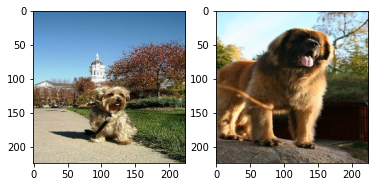

In [16]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break
    
plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [17]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)
    
    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(126, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)
y :  tf.Tensor(39, shape=(), dtype=int32) tf.Tensor(132, shape=(), dtype=int32)


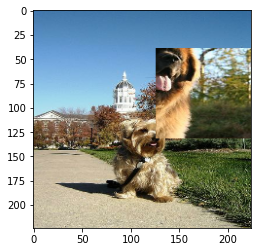

In [18]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

### 2. 라벨 섞기

In [19]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)

mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.8183594 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [20]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []
    
    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

## Mixup Augmentation

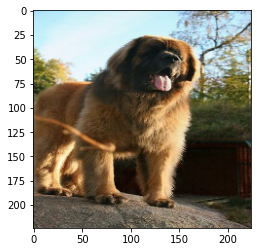

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.05539489 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [21]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
        
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
        
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)

plt.imshow(mixed_img.numpy())

plt.show()

print(mixed_label)

In [22]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []
    
    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)
        
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels